In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error #roc_auc_score as AUC
from sklearn.externals import joblib

import pickle
import time
import os.path
import math


# Load data

In [2]:
n_bytes = 2**31
max_bytes = 2**31 - 1

def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [3]:
train = load_pickle('train_df_after_preprocessing.pkl') # balanced class
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

#train_click = train['click']
train_click = train['click']
train_bidprice = train['bidprice']
train_payprice = train['payprice']
#train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)
train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

# GBDT+LR

In [88]:
from sklearn import metrics
# 导入数据  
# X = train.drop(['click','payprice','bidprice'], axis = 1) 
# y = train['click']
  
# 切分为测试集和训练集，比例0.5  
X_train, X_test, y_train, y_test = train_test_split(train_X, train_click, test_size=0.5)  
# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。  
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)  
  
# 弱分类器的数目  
n_estimator = 60
# 调用GBDT分类模型  
grd = GradientBoostingClassifier(n_estimators=n_estimator)  
# 默认参数
# GradientBoostingClassifier(loss='deviance', learning_rate=0.1,
#                            subsample=1.0, criterion='friedman_mse', 
#                            min_samples_split=2, min_samples_leaf=1, 
#                            min_weight_fraction_leaf=0.0, max_depth=3, 
#                            min_impurity_decrease=0.0, min_impurity_split=None, 
#                            init=None, random_state=None, max_features=None, 
#                            verbose=0, max_leaf_nodes=None, warm_start=False, 
#                            presort='auto',n_estimators=100)
  
# 调用one-hot编码。  
grd_enc = OneHotEncoder()  
  
# 调用LR分类模型。  
grd_lm = LogisticRegression(penalty='l2', dual=False, tol=0.0004, 
                            C=1.0,fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=None,
                            solver='liblinear', max_iter=85, 
                            multi_class='ovr', verbose=0,
                            warm_start=False, n_jobs=1)  
# 默认参数
# LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, 
#                    C=1.0, fit_intercept=True, intercept_scaling=1, 
#                    class_weight=None, random_state=None, 
#                    solver=’liblinear’, max_iter=100, 
#                    multi_class=’ovr’, verbose=0, 
#                    warm_start=False, n_jobs=1)
  
#使用X_train训练GBDT模型，后面用此模型构造特征  
grd.fit(X_train, y_train)  
  
#直接进行预测，查看AUC得分  
y_pred_grd = grd.predict_proba(X_test)[:, 1]  
fpr_grd, tpr_grd, _ = metrics.roc_curve(y_test, y_pred_grd)  
roc_auc = metrics.auc(fpr_grd, tpr_grd)  
print('predict',roc_auc)  
  
# fit one-hot编码器  
grd_enc.fit(grd.apply(X_train)[:, :, 0])  
  
#使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。  
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)  
  
# 用训练好的LR模型多X_test做预测  
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]  
  
# 根据预测结果输出  
fpr_grd_lm, tpr_grd_lm, _ = metrics.roc_curve(y_test, y_pred_grd_lm)  
roc_auc = metrics.auc(fpr_grd_lm, tpr_grd_lm)  
print('predict',roc_auc)
  
print("AUC Score :",(metrics.roc_auc_score(y_test, y_pred_grd_lm)))    

y_pred_grd_lm

predict 0.816159291418
predict 0.839437030174
AUC Score : 0.839437030174


array([ 0.46582816,  0.26644777,  0.38533551, ...,  0.09365811,
        0.9187488 ,  0.35221956])

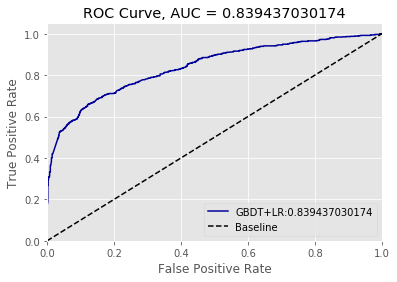

In [89]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots()
    ax.plot(fpr_grd_lm, tpr_grd_lm, "#000099", label='GBDT+LR:'+str(roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve, AUC = '+str(roc_auc))

In [90]:
joblib.dump(grd_lm, 'GBDT+LR' + ".pickle.dat" )

['GBDT+LR.pickle.dat']

In [91]:
model = joblib.load("GBDT+LR.pickle.dat")
valid_ctr_prediction=model.predict_proba(grd_enc.transform(grd.apply(valid_X)[:, :, 0]))[:, 1]  

# Squared Bidding: bid_price = base_bid * (pCTR / avgCTR) ^ 2

In [92]:
def EvaluateClick( bid_price, budget, valid_payprice, valid_click):
    
    auction = bid_price >= valid_payprice
    win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
    bid_spends = valid_payprice[win_bid_ix].values
    bid_clicks = valid_click[win_bid_ix].values

    budget = 6250000
    current_spend = sum(bid_spends)

    total_bids = len(bid_spends)

    for i in range(len(bid_spends)):

        current_spend -= bid_spends[total_bids-i-1]

        if current_spend <= budget:
            break

    final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
    bid_spends = sum(valid_payprice[final_win_bid_ix].values)
    bid_clicks = sum(valid_click[final_win_bid_ix].values)
    
    print('clicks:', bid_clicks, 'impressions:', len(final_win_bid_ix), 'spend:', bid_spends)

    return bid_clicks


clicks: 159 impressions: 97199 spend: 5372581
clicks: 160 impressions: 97818 spend: 5420206
clicks: 160 impressions: 98399 spend: 5466481
clicks: 160 impressions: 98963 spend: 5505494
clicks: 160 impressions: 99471 spend: 5547129
clicks: 160 impressions: 100105 spend: 5593923
clicks: 160 impressions: 100730 spend: 5640474
clicks: 160 impressions: 101310 spend: 5688787
clicks: 160 impressions: 101760 spend: 5723941
clicks: 160 impressions: 102240 spend: 5760753
clicks: 160 impressions: 102924 spend: 5808562
clicks: 160 impressions: 103340 spend: 5843785
clicks: 160 impressions: 104010 spend: 5896021
clicks: 161 impressions: 104487 spend: 5933053
clicks: 161 impressions: 104906 spend: 5969177
clicks: 161 impressions: 105370 spend: 6007619
clicks: 161 impressions: 105909 spend: 6048537
clicks: 161 impressions: 106300 spend: 6077835
clicks: 161 impressions: 106724 spend: 6115784
clicks: 161 impressions: 107417 spend: 6169035
clicks: 161 impressions: 107978 spend: 6213287
clicks: 161 impres

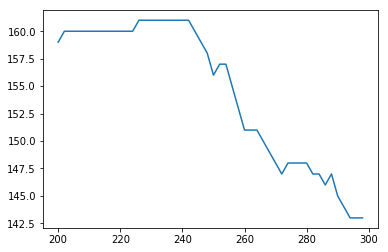

In [93]:
# search the best base_price
base_prices = np.arange(200,300,2)
clicks = []
budget = 6250000
avgCTR=0.738

for base in base_prices:
    
    valid_pctr = valid_ctr_prediction
    bid_price = [ int(base*(pCTR/avgCTR)**2) for pCTR in valid_pctr ]
    c = EvaluateClick( bid_price, budget, valid_payprice, valid_click);
    clicks.append(c)

    
plt.figure()
plt.plot(base_prices, clicks)
print('best constant:', base_prices[clicks.index(max(clicks))])

In [96]:
base = base_prices[clicks.index(max(clicks))]

bid_price = [ int(base*(pCTR/avgCTR)**2) for pCTR in valid_pctr ]
EvaluateClick( bid_price, budget , valid_payprice, valid_click)

clicks: 161 impressions: 104487 spend: 5933053


161

In [97]:
### prediction
base = base_prices[clicks.index(max(clicks))]

test_prediction = model.predict_proba(grd_enc.transform(grd.apply(test)[:, :, 0]))[:, 1]  
bid_price = [ int(base*(pCTR/avgCTR)**2) for pCTR in test_prediction ]

submission = pd.read_csv('Group_xx.csv')
submission['bidprice'] = bid_price
submission.to_csv('GBDT+LR_with_Squared.csv')